# Discovering structure behind data

Let's understand and modelize the hidden structure behind data with Decision Trees. In this tutorial, we'll explore and inspect how can a model do its decisions on a car evaluation data set. Decision trees works with simple "if" clauses dichotomically chained together, splitting the data flow recursively on those if until it reaches a leaf where we can categorize the data. Such data inspection could be used to reverse engineer the behavior of any function. 

Since [decision trees](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/) are a good algorithm for discovering the structure hidden behind data, we'll use and model the car evaluation data set, for which the prediction problem is a (deterministic) surjective function. This means that the inputs of the examples in the data set cover all the possibilities, and that for each possible input value, there is only one answer to predict (thus, two examples with the same input values would never have a different expected prediction). On the point of view of Data Science, because of the properties of our dataset, we won't need a test set nor to use cross validation. Thus, the error we will obtain below at modelizing our dataset would be equal to the true test error if we had a test set.

The attribute to predict in the data set could have been, for example, created from a programmatic function and we will basically reverse engineer the logic mapping the inputs to the outputs to recreate the function and to be able to explain it visually.


## About the Car Evaluation Data Set

For more information: http://archive.ics.uci.edu/ml/datasets/Car+Evaluation

### Overview

The Car Evaluation Database was derived from a simple hierarchical decision model originally developed for the demonstration of DEX, M. Bohanec, V. Rajkovic: Expert system for decision making. Sistemica 1(1), pp. 145-157, 1990.). The model evaluates cars according to the following concept structure: 

- CAR car acceptability:
  - PRICE overall price:
    - **buying** buying price
    - **maint price** of the maintenance
  - TECH technical characteristics:
    - COMFORT comfort:
      - **doors** number of doors
      - **persons** capacity in terms of persons to carry
      - **lug_boot** the size of luggage boot
    - **safety** estimated safety of the car

Input attributes are printed in lowercase. Besides the target concept (CAR), the model includes three intermediate concepts: PRICE, TECH, COMFORT. Every concept is in the original model related to its lower level descendants by a set of examples (for these examples sets see [Web Link]). 

The Car Evaluation Database contains examples with the structural information removed, i.e., directly relates CAR to the six input attributes: buying, maint, doors, persons, lug_boot, safety. 

Because of known underlying concept structure, this database may be particularly useful for testing constructive induction and structure discovery methods. 

### Attributes, instances, and Class Distribution

Number of Attributes: 6

Missing Attribute Values: none

| Attribute  | Values |
|------------|--------|
| buying     | v-high, high, med, low |
| maint      | v-high, high, med, low |
| doors      | 2, 3, 4, 5-more |
| persons    | 2, 4, more |
| lug_boot   | small, med, big |
| safety     | low, med, high |

Number of Instances: 1728 (Instances completely cover the attribute space.)

| class | N | N[%] |
|---|---|---|
| unacc | 1210 | 70.023 % |
| acc | 384 | 22.222 % |
| good | 69 | 3.993 % |
| v-good | 65 | 3.762 % |


## We'll now load the car evaluation data set in Python and then train decision trees

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_tree
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import os

### Define the features and preprocess the car evaluation data set

Note: you must have first downloaded the data by running `./download_data.sh` while in the repository's folder on an unix system (Lunix, Mac) or else open the script and manually go to the written urls to download the data. 

In [2]:
input_labels = [
    ["buying", ["vhigh", "high", "med", "low"]],
    ["maint", ["vhigh", "high", "med", "low"]],
    ["doors", ["2", "3", "4", "5more"]],
    ["persons", ["2", "4", "more"]],
    ["lug_boot", ["small", "med", "big"]],
    ["safety", ["low", "med", "high"]],
]

output_labels = ["unacc", "acc", "good", "vgood"]

# Load data set
data = np.genfromtxt(os.path.join('data', 'car.data'), delimiter=',', dtype="U")
data_inputs = data[:, :-1]
data_outputs = data[:, -1]

def str_data_to_one_hot(data, input_labels):
    """Convert each feature's string to a flattened one-hot array. """
    X_int = LabelEncoder().fit_transform(data.ravel()).reshape(*data.shape)
    X_bin = OneHotEncoder().fit_transform(X_int).toarray()
    
    attrs_names = []
    for a in input_labels:
        key = a[0]
        for b in a[1]:
            value = b
            attrs_names.append("{}_is_{}".format(key, value))

    return X_bin, attrs_names

def str_data_to_linear(data, input_labels):
    """Convert each feature's string to an integer index"""
    X_lin = np.array([[
        input_labels[a][1].index(j) for a, j in enumerate(i)
    ] for i in data])
    
    # Indexes will range from 0 to n-1
    attrs_names = [i[0] + "_index" for i in input_labels]
    
    return X_lin, attrs_names

# Take both one-hot and linear versions of input features: 
X_one_hot, attrs_names_one_hot = str_data_to_one_hot(data_inputs, input_labels)
X_linear_int, attrs_names_linear_int = str_data_to_linear(data_inputs, input_labels)

# Put that together:
X = np.concatenate([X_one_hot, X_linear_int], axis=-1)
attrs_names = attrs_names_one_hot + attrs_names_linear_int

# Outputs use indexes, this is not one-hot:
integer_y = np.array([output_labels.index(i) for i in data_outputs])

print("Data set's shape,")
print("X.shape, integer_y.shape, len(attrs_names), len(output_labels):")
print(X.shape, integer_y.shape, len(attrs_names), len(output_labels))

# Shaping the data into a single pandas dataframe for naming columns:
pdtrain = pd.DataFrame(X)
pdtrain.columns = attrs_names
dtrain = xgb.DMatrix(pdtrain, integer_y)

Data set's shape,
X.shape, integer_y.shape, len(attrs_names), len(output_labels):
(1728, 27) (1728,) 27 4


### Train simple decision trees (here using XGBoost) to fit the data set:

First, let's define some hyperparameters, such as the depth of the tree.

In [3]:

num_rounds = 1  # Do not use boosting for now, we want only 1 decision tree per class.
num_classes = len(output_labels)
num_trees = num_rounds * num_classes

# Let's use a max_depth of 4 for the sole goal of simplifying the visual representation produced
# (ideally, a tree would be deeper to classify perfectly on that dataset)
param = {
    'max_depth': 4,
    'objective': 'multi:softprob',
    'num_class': num_classes
}

bst = xgb.train(param, dtrain, num_boost_round=num_rounds)
print("Decision trees trained!")
print("Mean Error Rate:", bst.eval(dtrain))
print("Accuracy:", (bst.predict(dtrain).argmax(axis=-1) == integer_y).mean()*100, "%")

Decision trees trained!
Mean Error Rate: b'[0]\teval-merror:0.142940'
Accuracy: 85.7060185185 %


### Plot and save the trees (one for each class):

The 4 trees of the classifer (one tree per class) will each output a number that represents how much it is probable that the thing to classify belongs to that class, and it is by comparing the output at the end of all the trees for a given example that we could get the maximal output as associating the example to that class.  Indeed, the binary situation where we have only one tree that outputs a positive and else negative number would be simpler to interpret rather than classifying for 4 binary classes at once. 

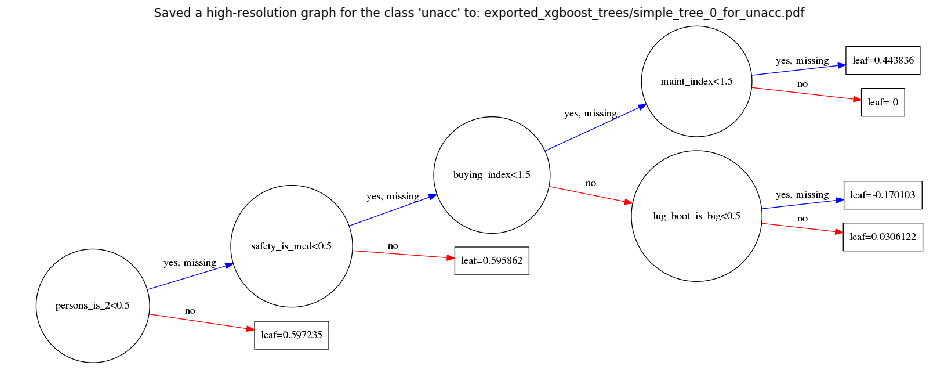

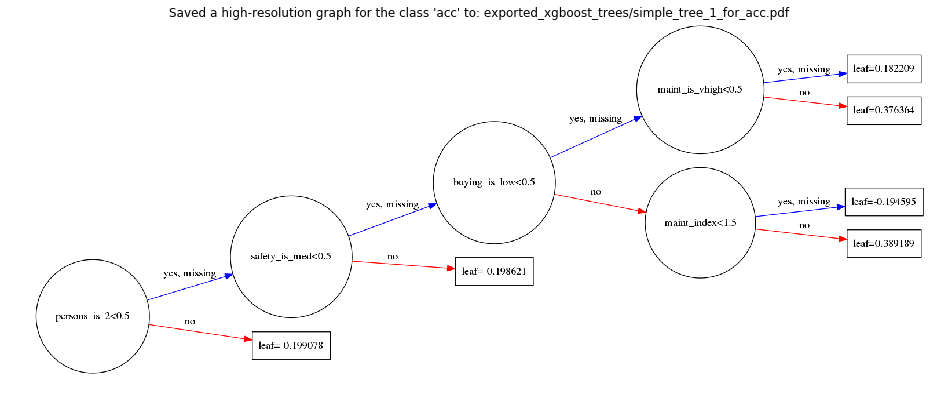

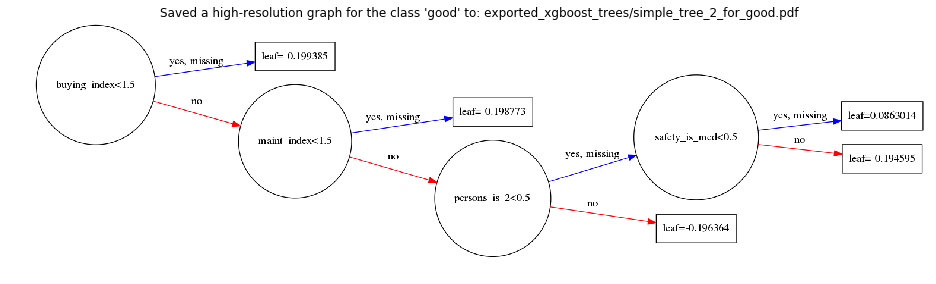

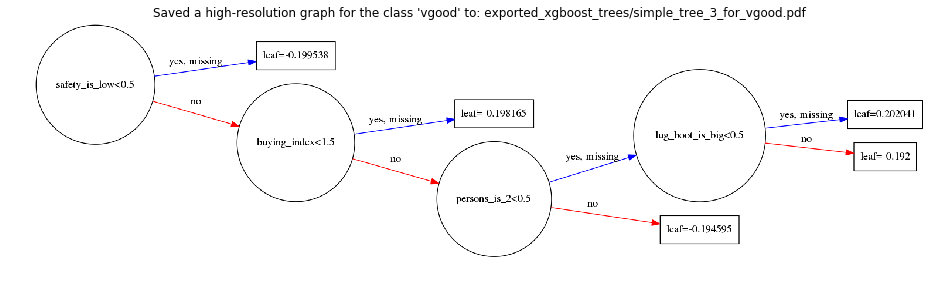

In [4]:
def plot_first_trees(bst, output_labels, trees_name):
    """
    Plot and save the first trees for multiclass classification
    before any boosting was performed.
    """
    for tree_idx in range(len(output_labels)):
        class_name = output_labels[tree_idx]
        graph_save_path = os.path.join(
            "exported_xgboost_trees", 
            "{}_{}_for_{}".format(trees_name, tree_idx, class_name)
        )

        graph = xgb.to_graphviz(bst, num_trees=tree_idx)
        graph.render(graph_save_path)

        # from IPython.display import display
        # display(graph)
        ### Inline display in the notebook would be too huge and would require much side scrolling.
        ### So we rather plot it anew with matplotlib and a fixed size for inline quick view purposes:
        fig, ax = plt.subplots(figsize=(16, 16)) 
        plot_tree(bst, num_trees=tree_idx, rankdir='LR', ax=ax)
        plt.title("Saved a high-resolution graph for the class '{}' to: {}.pdf".format(class_name, graph_save_path))
        plt.show()

# Plot our simple trees:
plot_first_trees(bst, output_labels, trees_name="simple_tree")

Note that the above trees can be viewed here online:
https://github.com/Vooban/Decision-Trees-For-Knowledge-Discovery/tree/master/exported_trees

### Plot the importance of each input features for those simple decision trees:

Note here that it is the feature importance according to our simple, shallow trees. More complex trees would include more of the features/attributes with different proportions. 

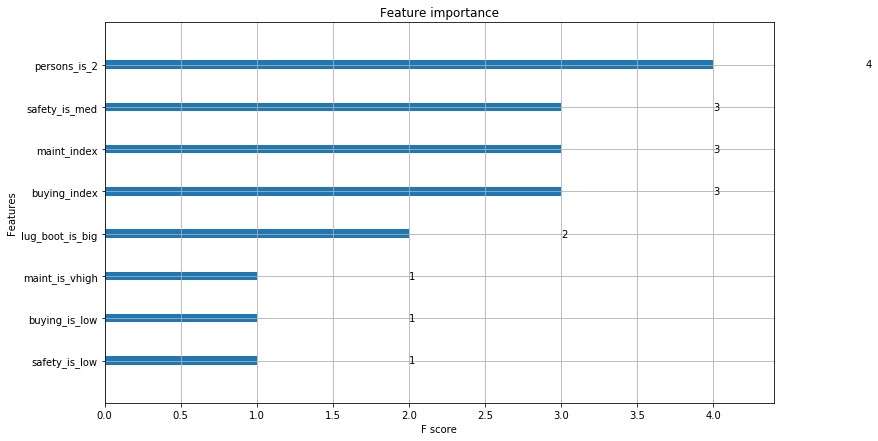

In [5]:
fig, ax = plt.subplots(figsize=(12, 7)) 
xgb.plot_importance(bst, ax=ax)
plt.show()

### Let's now generate slightly more complex trees to aid inspection

<a href="http://theinceptionbutton.com/" >
<p align="center">
  <img src="deeper.jpg" />
</p>
</a>

Let's [go deeper](http://theinceptionbutton.com/) and build deeper trees. However, those trees are not maximally complex since XGBoost is rather built to boost over forests of small trees than a big one.

In [6]:
num_rounds = 1  # Do not use boosting for now, we want only 1 decision tree per class.
num_classes = len(output_labels)
num_trees = num_rounds * num_classes

# Let's use a max_depth of 4 for the sole goal of simplifying the visual representation produced
# (ideally, a tree would be deeper to classify perfectly on that dataset)
param = {
    'max_depth': 9,
    'objective': 'multi:softprob',
    'num_class': num_classes
}

bst = xgb.train(param, dtrain, num_boost_round=num_rounds)
print("Decision trees trained!")
print("Mean Error Rate:", bst.eval(dtrain))
print("Accuracy:", (bst.predict(dtrain).argmax(axis=-1) == integer_y).mean()*100, "%")

Decision trees trained!
Mean Error Rate: b'[0]\teval-merror:0.017940'
Accuracy: 98.2060185185 %


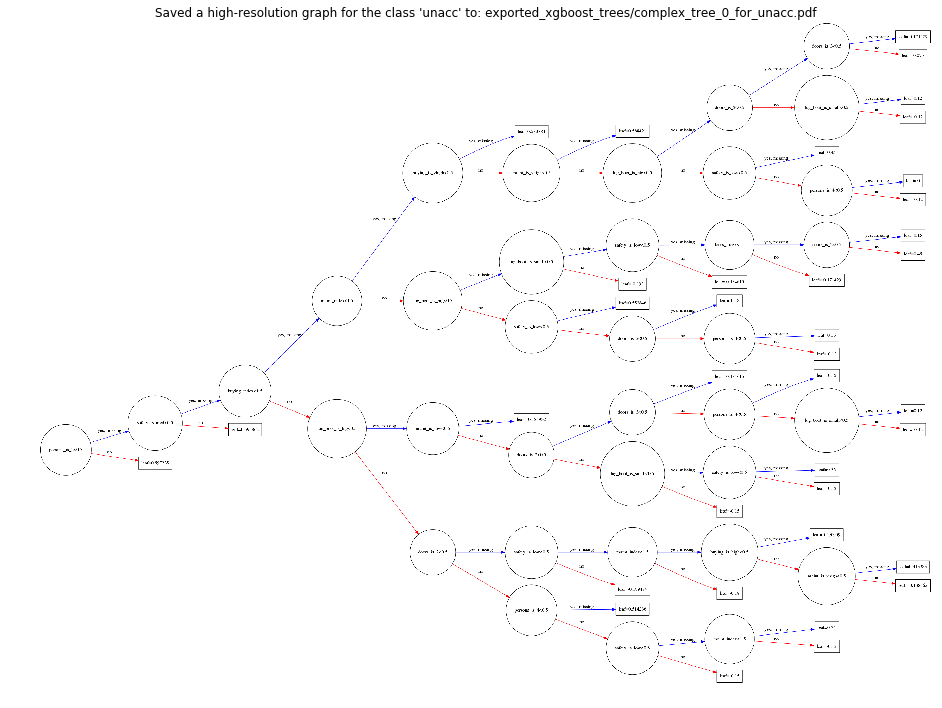

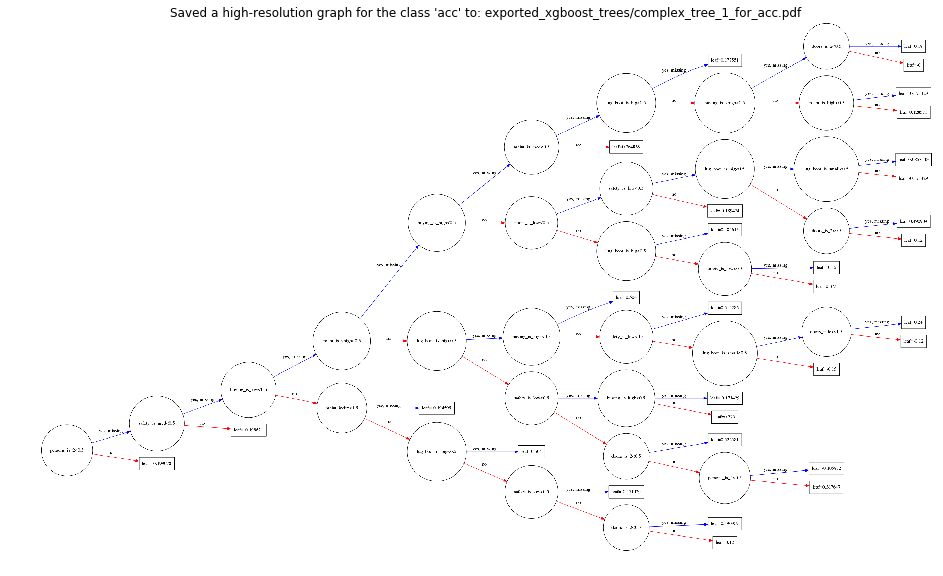

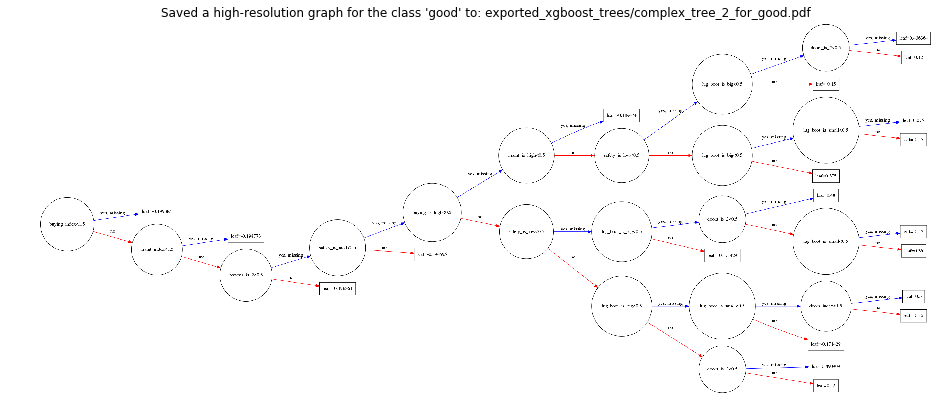

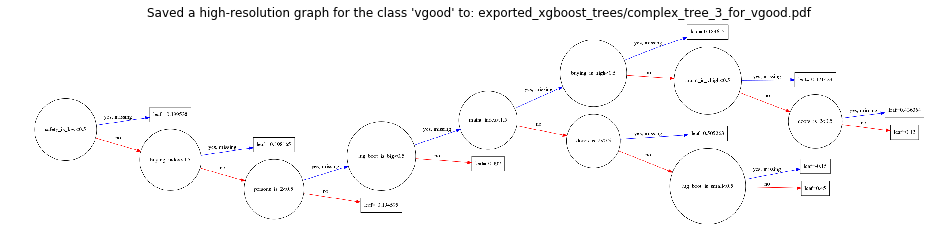

Now, our feature importance chart considers more features, but it is still not complete.


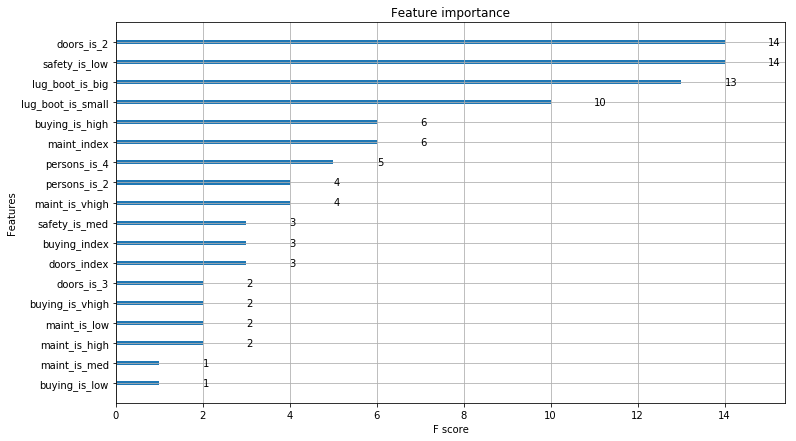

In [7]:
# Plot our complex trees:
plot_first_trees(bst, output_labels, trees_name="complex_tree")

# And their feature importance:
print("Now, our feature importance chart considers more features, but it is still not complete.")
fig, ax = plt.subplots(figsize=(12, 7)) 
xgb.plot_importance(bst, ax=ax)
plt.show()

Note that the above trees can be viewed here online:
https://github.com/Vooban/Decision-Trees-For-Knowledge-Discovery/tree/master/exported_trees

### Finding a perfect classifier rather than an easily explainable one

We'll now use boosting. The resulting trees can't be explained as easily as the previous ones, since one classifier will now have incrementally many trees for each class to reduce error, each new trees based on the errors of the previous ones. And those trees will each be weighted. 

In [8]:
num_rounds = 10  # 10 rounds of boosting, thus 10 trees per class. 
num_classes = len(output_labels)
num_trees = num_rounds * num_classes

param = {
    'max_depth': 20,
    'eta': 1.43,
    'objective': 'multi:softprob',
    'num_class': num_classes,
}

bst = xgb.train(param, dtrain, early_stopping_rounds=1, num_boost_round=num_rounds, evals=[(dtrain, "dtrain")])
print("Boosted decision trees trained!")
print("Mean Error Rate:", bst.eval(dtrain))
print("Accuracy:", (bst.predict(dtrain).argmax(axis=-1) == integer_y).mean()*100, "%")

[0]	dtrain-merror:0.016782
Will train until dtrain-merror hasn't improved in 1 rounds.
[1]	dtrain-merror:0.002315
[2]	dtrain-merror:0
[3]	dtrain-merror:0
Stopping. Best iteration:
[2]	dtrain-merror:0

Boosted decision trees trained!
Mean Error Rate: b'[0]\teval-merror:0.000000'
Accuracy: 100.0 %


In our case, note that it is possible to have an error of 0 (thus an accuracy of 100%) since we have a dataset that represents a function, which is mathematically deterministic and could be interpreted as programmatically pure in the case it would be implemented. But wait... we just implemented and recreated the function that was used to modelize the dataset with our trees! We don't need cross validation nor a test set, because our training data already covers the full feature space (attribute space). 

### Finally, the full attributes/features importance:

Importance type: weight


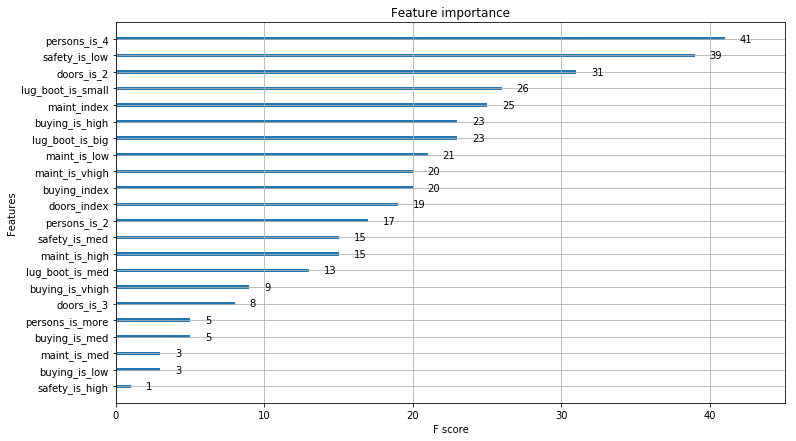

Importance type: gain


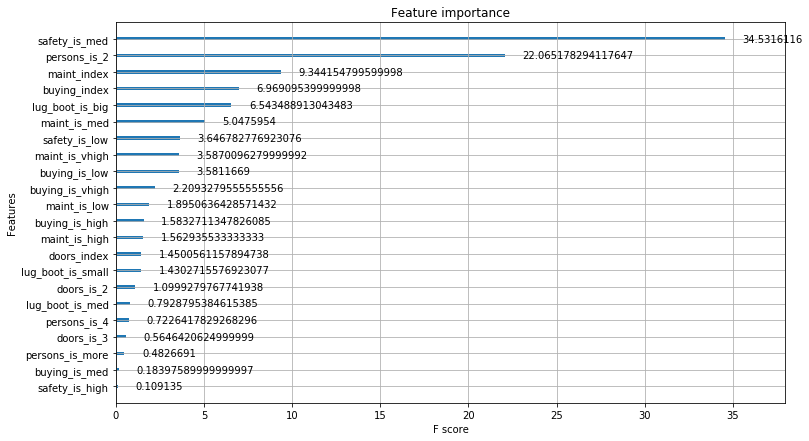

Importance type: cover


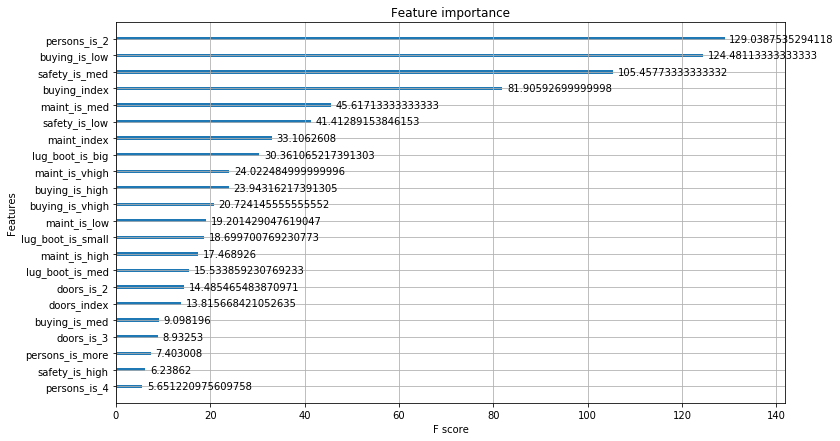

In [9]:
# Some plot options from the doc:
# importance_type : str, default "weight"
#     How the importance is calculated: either "weight", "gain", or "cover"
#     "weight" is the number of times a feature appears in a tree
#     "gain" is the average gain of splits which use the feature
#     "cover" is the average coverage of splits which use the feature
#         where coverage is defined as the number of samples affected by the split

importance_types = ["weight", "gain", "cover"]
for i in importance_types:
    print("Importance type:", i)
    fig, ax = plt.subplots(figsize=(12, 7))
    xgb.plot_importance(bst, importance_type=i, ax=ax)
    plt.show()

## Conclusion

To sum up, we achieved to get a good classification result and to be able to explain those results visually and automatically. Here, we did classification (so we requred 4 trees - one for each class), but also note that it would have been possible to solve a regression problem, too, such as predicting a price rather than a category, using a single tree.

Such a technique would be useful in reverse engineering an existing system, such as an old one that has been coded in a peculiar programming language and for which the employees who coded that have left. This technique can also be used for data mining and gaining business intelligence, insights from data. 

Decision trees are good to model data sets and XGBoost has revealed to be a <a link="http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/">quite good algorithm for winning Kaggle competitions</a>. Using XGBoost can lead to great results in plus of being interesting for roughly explaining how classifications are made on data. However, XGBoost is normally used for boosting trees (also called gradient boosting) and the resulting forest is hard to interpret. Each tree is trained on the errors of the previous ones until the error gets at its lowest.

In [10]:
# Let's convert this notebook to a README for the GitHub project's title page:
!jupyter nbconvert --to markdown Decision-Trees-For-Knowledge-Discovery.ipynb
!mv Decision-Trees-For-Knowledge-Discovery.md README.md

[NbConvertApp] Converting notebook Decision-Trees-For-Knowledge-Discovery.ipynb to markdown
[NbConvertApp] Support files will be in Decision-Trees-For-Knowledge-Discovery_files/
[NbConvertApp] Making directory Decision-Trees-For-Knowledge-Discovery_files
[NbConvertApp] Making directory Decision-Trees-For-Knowledge-Discovery_files
[NbConvertApp] Making directory Decision-Trees-For-Knowledge-Discovery_files
[NbConvertApp] Making directory Decision-Trees-For-Knowledge-Discovery_files
[NbConvertApp] Making directory Decision-Trees-For-Knowledge-Discovery_files
[NbConvertApp] Making directory Decision-Trees-For-Knowledge-Discovery_files
[NbConvertApp] Making directory Decision-Trees-For-Knowledge-Discovery_files
[NbConvertApp] Making directory Decision-Trees-For-Knowledge-Discovery_files
[NbConvertApp] Making directory Decision-Trees-For-Knowledge-Discovery_files
[NbConvertApp] Making directory Decision-Trees-For-Knowledge-Discovery_files
[NbConvertApp] Making directory Decision-Trees-For-K